In [33]:
import ast
import tempfile
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
import numpy as np
from PIL import Image, ImageFile
from datetime import datetime
from tensorflow import keras
from tensorflow.keras.models import Sequential
from hentai import Utils, Hentai, Option
from pathlib import Path

## Package flags

In [34]:
ImageFile.LOAD_TRUNCATED_IMAGES = True


## Data Collection

We will be using the doujin dataset obtained from nhentai.

In [35]:
N_SAMPLE = 0 # Number of sample to refetch from hentai.

## Download dataset

In [36]:
samples_df = pd.DataFrame([Utils.get_random_hentai() for _ in range(0, N_SAMPLE)])
samples_df = samples_df.apply(lambda x: x.dictionary(Option.all()))
data_path = Path("data/train")
metadata_path = data_path / "metadata.csv"
if not metadata_path.is_file():
   samples_df.to_csv(metadata_path, index=False, header="column_names")
else:
   samples_df.to_csv(metadata_path, index=False, mode="a", header=False)
print("Number of resampled samples: ", len(samples_df))


Number of resampled samples:  0


## Read dataset file

In [37]:
converters = {
    column_name: ast.literal_eval
    for column_name in ["tag", "group", "parody", "character", "artist", "category", "image_urls"]
}
hentais_df = pd.read_csv(metadata_path, converters=converters)
hentais_df

,id,title,scanlator,url,api,media_id,epos,num_favorites,tag,group,parody,character,language,artist,category,cover,thumbnail,image_urls,num_pages
0,119610,ONESeiyoku no Fubuki,NaN,https://nhentai.net/g/119610,https://nhentai.net/api/gallery/119610,753376,1414863776,536,"[sleeping, virginity, muscle, defloration, thi...",[kiyosumi hurricane],[one punch man],"[jigoku no fubuki, saitama]",['japanese'],[kiyosumi hurricane],[doujinshi],https://t.nhentai.net/galleries/753376/cover.jpg,https://t.nhentai.net/galleries/753376/thumb.jpg,"[https://i.nhentai.net/galleries/753376/1.jpg,...",40
1,182750,Uchuu Fukei Karen Junsa| Space Police Karen Ch. 1,NaN,https://nhentai.net/g/182750,https://nhentai.net/api/gallery/182750,1011714,1483131337,552,"[glasses, big breasts, pasties, policewoman, r...",[],[],[],"['english', 'translated']",[kamitou masaki],[manga],https://t.nhentai.net/galleries/1011714/cover.jpg,https://t.nhentai.net/galleries/1011714/thumb.jpg,[https://i.nhentai.net/galleries/1011714/1.jpg...,47
2,270524,15wa no ma no mobu doro,NaN,https://nhentai.net/g/270524,https://nhentai.net/api/gallery/270524,1406430,1556621537,136,"[lolicon, rape, tomboy, group, collar, sole fe...",[],[dororo],[],['japanese'],[],[doujinshi],https://t.nhentai.net/galleries/1406430/cover.jpg,https://t.nhentai.net/galleries/1406430/thumb.jpg,[https://i.nhentai.net/galleries/1406430/1.jpg...,12
3,1215,Robot Erotica,NaN,https://nhentai.net/g/1215,https://nhentai.net/api/gallery/1215,3217,1403966715,115,"[futanari, big breasts, lactation]",[narisawa hatsudensho],[xenosaga],"[shion uzuki, kos-mos]","['english', 'rewrite']",[neriwasabi],[doujinshi],https://t.nhentai.net/galleries/3217/cover.jpg,https://t.nhentai.net/galleries/3217/thumb.jpg,"[https://i.nhentai.net/galleries/3217/1.jpg, h...",21
4,292757,Shoukaku to Motto Ichaicha Shitai!! | I Want T...,NaN,https://nhentai.net/g/292757,https://nhentai.net/api/gallery/292757,1527780,1575438197,3681,"[sole male, big breasts, sole female, multi-wo...",[tonpuuratei],[kantai collection],"[shoukaku, teitoku]","['english', 'translated']",[saemon],[doujinshi],https://t.nhentai.net/galleries/1527780/cover.jpg,https://t.nhentai.net/galleries/1527780/thumb.jpg,[https://i.nhentai.net/galleries/1527780/1.jpg...,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192,85836,VS,NaN,https://nhentai.net/g/85836,https://nhentai.net/api/gallery/85836,560149,1403997802,23,"[futanari, demon girl, lolicon]",[erotical combat],"[street fighter, darkstalkers, megaman]","[roll, sonson]",['japanese'],[nagasaki biidoro],[doujinshi],https://t.nhentai.net/galleries/560149/cover.jpg,https://t.nhentai.net/galleries/560149/thumb.jpg,"[https://i.nhentai.net/galleries/560149/1.jpg,...",34
193,155485,Boku to Haha to Itoko,NaN,https://nhentai.net/g/155485,https://nhentai.net/api/gallery/155485,898587,1454002824,680,"[full color, incest, mosaic censorship, big br...",[],[],[],['japanese'],[],[manga],https://t.nhentai.net/galleries/898587/cover.jpg,https://t.nhentai.net/galleries/898587/thumb.jpg,"[https://i.nhentai.net/galleries/898587/1.jpg,...",24
194,29542,"Kyoudai SM Monogatari ""7days fuzz""Chuuhen",NaN,https://nhentai.net/g/29542,https://nhentai.net/api/gallery/29542,125108,1403987594,140,"[bdsm, asphyxiation, bondage, human pet, colla...",[mousou kai no juunin wa ikiteiru.],[],[],['japanese'],[kandanchi],[doujinshi],https://t.nhentai.net/galleries/125108/cover.jpg,https://t.nhentai.net/galleries/125108/thumb.jpg,"[https://i.nhentai.net/galleries/125108/1.jpg,...",72
195,102364,Dying Arnis,NaN,https://nhentai.net/g/102364,https://nhentai.net/api/gallery/102364,656291,1404000946,10,"[elf, blood]",[],[],[],['japanese'],[yamamoto atsuji],[doujinshi],https://t.nhentai.net/galleries/656291/cover.jpg,https://t.nhentai.net/galleries/656291/thumb.jpg,"[https://i.nhentai.net/galleries/656291/1.jpg,...",34


## Download images

In [38]:
for _, hentai in hentais_df.iterrows():
    hentai_path = data_path / str(hentai.id)
    if not hentai_path.is_dir():
        hentai = Hentai(hentai.id)
        hentai.download(hentai_path, progressbar=True)

## Data preparation

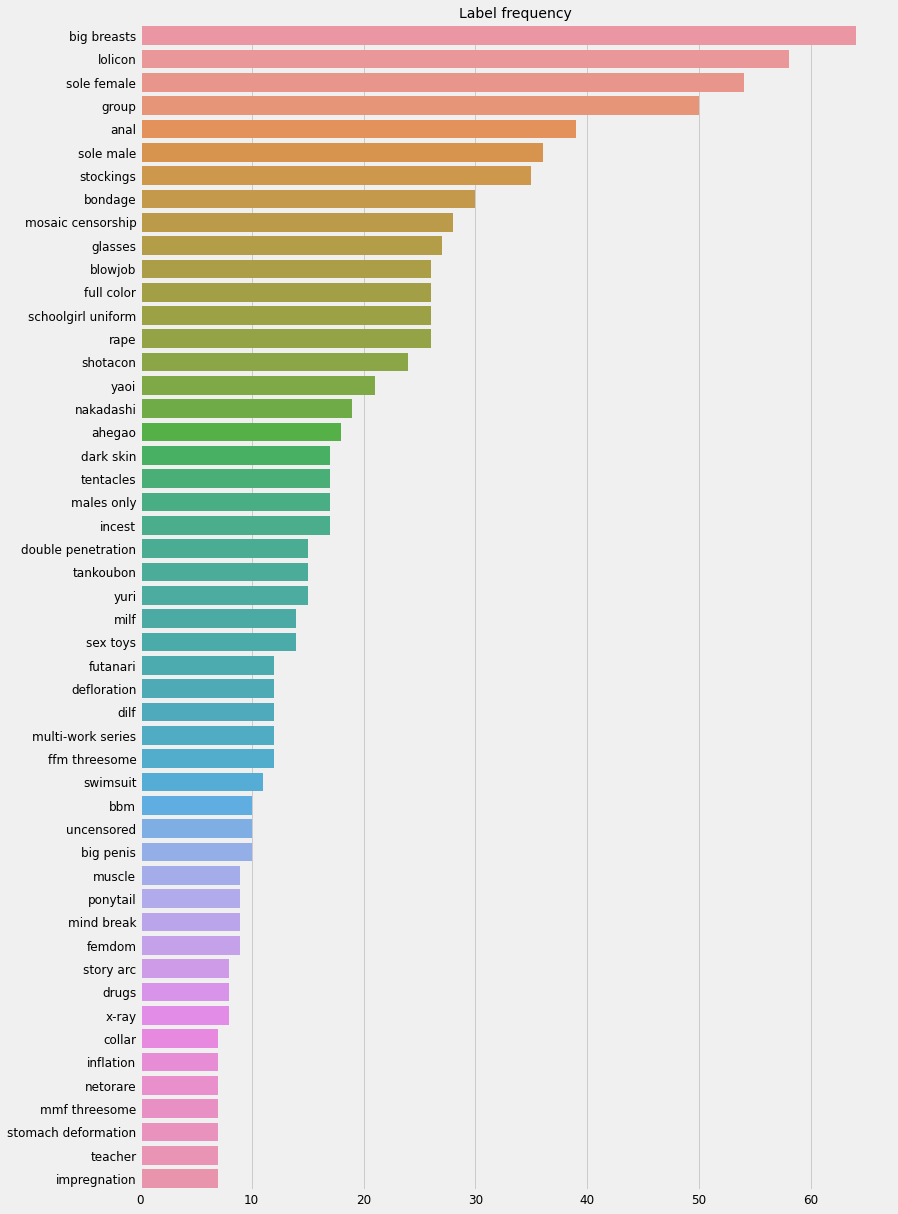

In [39]:
label_freq = hentais_df["tag"].explode().value_counts().sort_values(ascending=False).head(50)

style.use("fivethirtyeight")
plt.figure(figsize=(12, 20))
sns.barplot(y=label_freq.index.values, x=label_freq, order=label_freq.index)
plt.title("Label frequency", fontsize=14)
plt.xlabel("")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

## Data sparsity

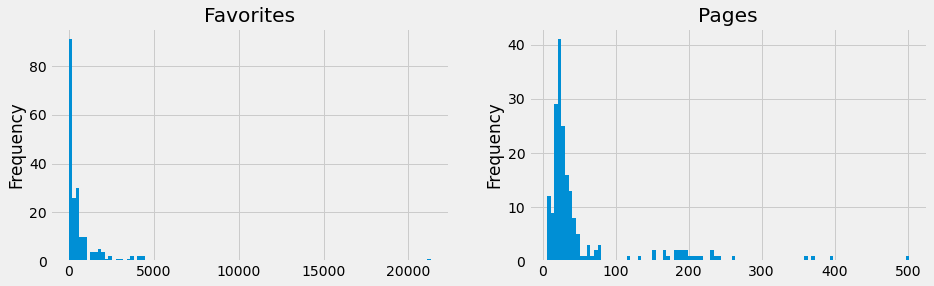

In [40]:
nobjs = 2 # Maximum number of images to display
ncols = 2 # Number of columns in display
nrows = nobjs // ncols # Number of rows in display
plt.figure(figsize=(14, 4 * nrows))
hentais_df["num_favorites"].plot.hist(ax=plt.subplot(nrows, ncols, 1), bins=100, title="Favorites")
hentais_df["num_pages"].plot.hist(ax=plt.subplot(nrows, ncols, 2), bins=100, title="Pages")
plt.show()

We need to complete the full path to locate training and test images from the current working directory.

In [41]:
hentais_df = hentais_df.explode("image_urls").reset_index()
filenames_df = hentais_df.apply(lambda x: str(Path(str(x["id"])) / Path(x["image_urls"]).name), axis=1).rename("filename")
labels_df = hentais_df["tag"].rename("labels")
hentais_df = pd.concat([filenames_df, labels_df], axis=1)
hentais_df

,filename,labels
0,119610\1.jpg,"[sleeping, virginity, muscle, defloration, thi..."
1,119610\2.jpg,"[sleeping, virginity, muscle, defloration, thi..."
2,119610\3.jpg,"[sleeping, virginity, muscle, defloration, thi..."
3,119610\4.jpg,"[sleeping, virginity, muscle, defloration, thi..."
4,119610\5.jpg,"[sleeping, virginity, muscle, defloration, thi..."
...,...,...
10946,143070\18.jpg,"[ahegao, big breasts, eyepatch, mecha girl, sc..."
10947,143070\19.jpg,"[ahegao, big breasts, eyepatch, mecha girl, sc..."
10948,143070\20.jpg,"[ahegao, big breasts, eyepatch, mecha girl, sc..."
10949,143070\21.jpg,"[ahegao, big breasts, eyepatch, mecha girl, sc..."


## Image examples

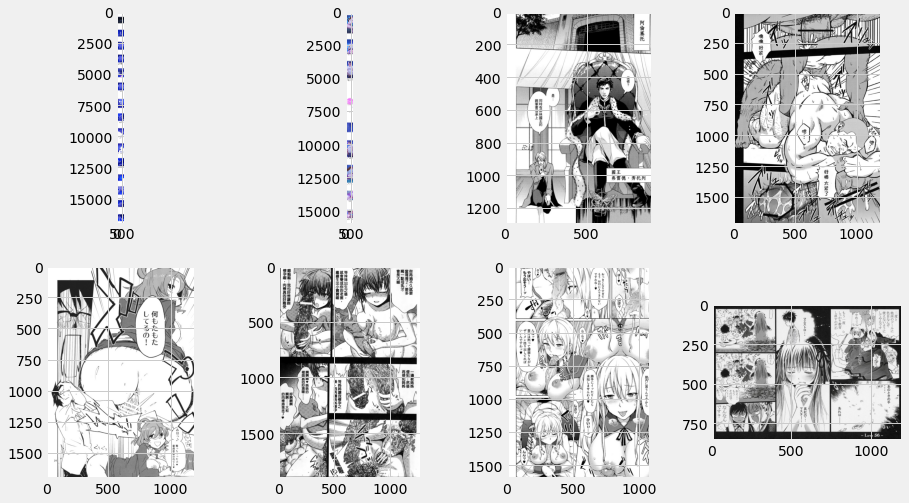

In [42]:

nobjs = 8 # Maximum number of images to display
ncols = 4 # Number of columns in display
nrows = nobjs // ncols # Number of rows in display
samples = hentais_df["filename"].explode().apply(lambda x: str(data_path / x)).sample(nrows * ncols)
plt.figure(figsize=(14, 4 * nrows))
for i, img in enumerate(samples):
    ax = plt.subplot(nrows, ncols, i+1)
    ax.imshow(Image.open(img).convert("RGB"))

## Tensorflow DataSet

In [43]:
hentais_gen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

In [44]:
BATCH_SIZE = 25 # Big enough to measure an F1-score
IMG_SIZE = 224 # Specify height and width of image to match the input format of the model
CHANNELS = 3 # Keep RGB color channels to match the input format of the model

In [51]:
train_ds = hentais_gen.flow_from_dataframe(
    dataframe=hentais_df,
    directory="data/train",
    x_col="filename",
    y_col="labels",
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    target_size=(IMG_SIZE, IMG_SIZE),
    shuffle=True,
    seed=44,
    subset="training"
)
val_ds = hentais_gen.flow_from_dataframe(
    dataframe=hentais_df,
    directory="data/train",
    x_col="filename",
    y_col="labels",
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    target_size=(IMG_SIZE, IMG_SIZE),
    subset="validation"
)

C:\Anaconda3\envs\bepeka\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:282: UserWarning: Found 37 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)
Found 8732 validated image filenames belonging to 262 classes.
C:\Anaconda3\envs\bepeka\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:282: UserWarning: Found 37 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)
Found 2182 validated image filenames belonging to 262 classes.


In [46]:
nlabels = len(train_ds.class_indices)
print("Number of hentais labels: ", nlabels)

Number of hentais labels:  0


## Transfert learning feature extractor

In [47]:
model = Sequential([
    hub.KerasLayer(
        "https://tfhub.dev/google/imagenet/mobilenet_v3_large_075_224/feature_vector/5",
        input_shape=(IMG_SIZE, IMG_SIZE, CHANNELS),
        trainable=False
    ),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dense(nlabels, activation="sigmoid")
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2731616   
_________________________________________________________________
dense (Dense)                (None, 64)                81984     
_________________________________________________________________
dense_1 (Dense)              (None, 0)                 0         
Total params: 2,813,600
Trainable params: 81,984
Non-trainable params: 2,731,616
_________________________________________________________________


## Train the model
Specify the learning rate and the number of training epochs (number of loops over the whole dataset).

In [49]:
LR = 1e-5 # Keep it small when transfer learning
EPOCHS = 30

In [50]:
model.compile(loss="binary_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=LR), metrics=["accuracy"])

In [17]:
output_dir = Path("job")
timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
savedmodel_dir = output_dir / "export/savedmodel"
model_export_path = savedmodel_dir / timestamp
checkpoint_path = output_dir / "checkpoints"
tensorboard_path = output_dir / "tensorboard"

In [ ]:
callbacks = [
    keras.callbacks.ReduceLROnPlateau(),
    keras.callbacks.EarlyStopping(patience=2),
    keras.callbacks.TensorBoard(str(tensorboard_path)),
    keras.callbacks.ModelCheckpoint(str(checkpoint_path)),
]

history = model.fit(train_ds, epochs=EPOCHS, validation_data=val_ds, callbacks=callbacks)

In [ ]:
plt.figure(figsize=(14, 4))

ax = plt.subplot(1, 2, 1)
ax.plot(history.history["accuracy"])
ax.plot(history.history["val_accuracy"])
ax.title("model accuracy")
ax.ylabel("accuracy")
ax.xlabel("epoch")
ax.legend(["train", "validation"])

ax = plt.subplot(1, 2, 2)
ax.plot(history.history["loss"])
ax.plot(history.history["val_loss"])
ax.title("model loss")
ax.ylabel("loss")
ax.xlabel("epoch")
ax.legend(["train", "validation"])
plt.show()

In [ ]:
tf.saved_model.save(model, str(model_export_path))

## Show predictions

We can try and see what the predictions will look like when using our model on pages of some known hentais.
The following function simplifies the process of preparing poster data, generating the prediction from the model and visualizing it.

In [56]:
model = tf.saved_model.load(str("./job/export/savedmodel/20210429170550/"))

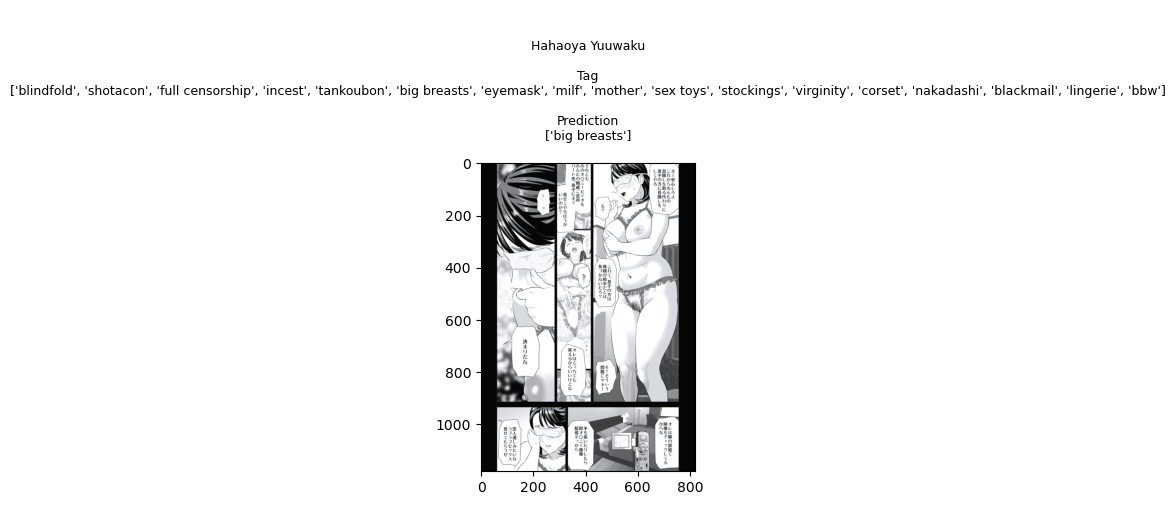

In [116]:
title = "Hahaoya Yuuwaku"

# Get hentai info
metadata_path = Path("data/test") / "metadata.csv"
hentais_df = pd.read_csv(metadata_path, converters=converters)
tag = hentais_df.loc[hentais_df["title"]==title]["tag"].iloc[0]
hentais_df = hentais_df.explode("image_urls").reset_index()
filenames_df = hentais_df.apply(lambda x: str(Path(str(x["id"])) / Path(x["image_urls"]).name), axis=1).rename("filename")
labels_df = hentais_df["tag"].rename("labels")
hentais_df = pd.concat([filenames_df, labels_df], axis=1)
img_path = Path("data/test") / hentais_df.loc[22].filename

# Read and prepare image
img = keras.preprocessing.image.load_img(img_path, target_size=(IMG_SIZE,IMG_SIZE,CHANNELS))
img = keras.preprocessing.image.img_to_array(img)
img = img / 255
img = np.expand_dims(img, axis=0)

# Generate prediction
prediction = model(img)
labels = dict((v,k) for k,v in train_ds.class_indices.items())
prediction = pd.Series(prediction[0])  > 0.3
prediction.index = train_ds.class_indices.keys()
prediction = prediction[prediction==1].index.values

# Dispaly image with prediction
style.use("default")
plt.figure(figsize=(8,4))
plt.imshow(Image.open(img_path))
plt.title("\n\n{}\n\nTag\n{}\n\nPrediction\n{}\n".format(title, tag, list(prediction)), fontsize=9)
plt.show()